# <center>Object Detection using Haar feature-based cascade classifiers:<br><br>`Viola-Jones face detection`</center>
---
### <center> made for </center> ![](realeyes.png)
---
At the end of this document I will suggest one more model – based on Support Vector Machines (SVM). As you will see below, I haven't used any kind of high-level language descriptors, nor any Machine Learning libraries (e.g. `sickit-learn`) – for the sake of learning, and clear mathematics. At the **summarisation and comments** section I will list all the possible language descriptors, analysis techniques and methodologies, that might come helpful for spam detection.

**I hope**, that as a Machine Learning Intern at LogMeIn I will have the chance to implement those suggested ideas (beside *Naive Bayes classifier*), and build many more Machine Learning based algorithms.

---
I have used the following external libraries (please, install those libraries if you want to execute the following cells):<br>
* [numpy](http://www.numpy.org)
* [plotly](https://plot.ly)
---

### list the available haarcascades first

below with bold those, I have used through implementation

`ls /haarcascades/`
***
**`haarcascade_eye.xml`**

`haarcascade_eye_tree_eyeglasses.xml
haarcascade_frontalcatface.xml
haarcascade_frontalcatface_extended.xml
haarcascade_frontalface_alt.xml`

**`haarcascade_frontalface_alt2.xml`**

`haarcascade_frontalface_alt_tree.xml
haarcascade_frontalface_default.xml
haarcascade_fullbody.xml
haarcascade_lefteye_2splits.xml
haarcascade_licence_plate_rus_16stages.xml
haarcascade_lowerbody.xml
haarcascade_profileface.xml
haarcascade_righteye_2splits.xml
haarcascade_russian_plate_number.xml
haarcascade_smile.xml
haarcascade_upperbody.xml
haarcascade_mcs_eyepair_big.xml
haarcascade_mcs_eyepair_small.xml
haarcascade_mcs_leftear.xml
haarcascade_mcs_lefteye.xml
haarcascade_mcs_lefteye_alt.xml`

**`haarcascade_mcs_mouth.xml
haarcascade_mcs_nose.xml`**

`haarcascade_mcs_rightear.xml
haarcascade_mcs_righteye.xml
haarcascade_mcs_righteye_alt.xml
haarcascade_mcs_upperbody.xml`

***
### import necessary libraries:

In [23]:
import numpy as np
import cv2
import argparse
import imutils
from timeit import default_timer as timer
import os
import time
import random

### `FoundSubFeature` Class holds advanced properties of subface-features instead of default `[x,y,w,h]` properties:

In [14]:
class FoundSubFeature:
    def __init__(self,parent,subf_x,subf_y,subf_w,subf_h,face_x,face_y,face_w,face_h):
        self.parent = parent
        self.midpoint = [subf_x+subf_w/2,subf_y+subf_h/2]
        self.midpoint_global = [self.midpoint[0]+face_x,self.midpoint[1]+face_y]

        self.face_midpoint = [face_x+face_w/2,face_y+face_h/2]
        self.relative_midpoint = [self.midpoint[0]-face_w/2,self.midpoint[1]-face_h/2]
        self.relative_midpoint_percentage = [self.relative_midpoint[0]/face_w*100,self.relative_midpoint[1]/face_h*100]

        self.bounding_box = [subf_w,subf_h]
        self.size = subf_w*subf_h
        self.face_box = [face_w,face_h]
        face_size = face_w*face_h
        self.relative_size_percentage = self.size/face_size*100
        

## `detector` represents Viola-Jones detector:

In [15]:
def detector(img,face_cascade,subfeature_cascades):

    results = []
    face_index = 0

    # img = imutils.resize(img, width = 300)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    found_faces = face_cascade.detectMultiScale(gray)

    for (face_x,face_y,face_w,face_h) in found_faces:
        
        face_index += 1

        # face rectangles
        cv2.rectangle(img,(face_x,face_y),(face_x+face_w,face_y+face_h),(241,240,236),2)

        # roi based on found_faces
        roi_gray = gray[face_y:face_y+face_h, face_x:face_x+face_w]
        roi_color = img[face_y:face_y+face_h, face_x:face_x+face_w]

        # applying subfeature_cascades
        found_subfeatures = []
        
        for cascade in subfeature_cascades:
            found_subfeatures.append([])
            objects = cascade.detectMultiScale(roi_gray,scaleFactor=1.05)
            if len(objects) != 0:
                for element in objects.tolist():
                    found_subfeatures[-1].append(FoundSubFeature(face_index,element[0],element[1],element[2],element[3],face_x,face_y,face_w,face_h))
        results.append(found_subfeatures)
        
    return results

### drawing function based on `FoundSubFeature` Class:

In [62]:
def drawRectangleForSubFeature(img,FoundSubFeature,color):   
    vertex_1 = tuple([int(x) for x in [sum(element) for element in zip(FoundSubFeature.face_midpoint,FoundSubFeature.relative_midpoint,[x / -2 for x in FoundSubFeature.bounding_box])]])
    vertex_2 = tuple([int(x) for x in [sum(element) for element in zip(FoundSubFeature.face_midpoint,FoundSubFeature.relative_midpoint,[x / 2 for x in FoundSubFeature.bounding_box])]])
    cv2.rectangle(img,vertex_1,vertex_2,color,1)

def drawImageDetection(image,result,features):
    clouds = [241, 240, 236]
    alizarin = [60, 76, 231]
    peterriver = [219, 152, 52]
    nephritis = [96, 174, 39]
    colors = [clouds,alizarin,peterriver,nephritis]
    # len(colors) must not be less than len(features)
    
    for face in result:
        for subfeature in face:
            for element in subfeature:
                drawRectangleForSubFeature(image,element,colors[face.index(subfeature)])
    
    image_height = image.shape[0]
    image_width = image.shape[1]
    for feature in features:
        (x,y) = (int(image_width*0.7),int(image_height*0.3+features.index(feature)*50))
        cv2.putText(image,feature,(x,y),cv2.FONT_HERSHEY_SIMPLEX, int(image_width*0.005), colors[features.index(feature)])
    return image

### proper inline image display in `Jupyter notebook` requires a custom function:

In [18]:
from matplotlib import pyplot as plt
def showImage(image):
    b,g,r = cv2.split(image)
    img_rgb = cv2.merge([r,g,b])
    
    figure = plt.figure(figsize = (100,10))
    plt.imshow(img_rgb)
    plt.show()

### Class to hold the image itself and its detected result:

In [19]:
class DetectedImage:
    def __init__(self,image_name,image,result):
        self.image_name = image_name
        self.image = image
        self.result = result

---
# evaluate Viola-Jones detector (without parameters) for each images in user defined `directory`*
### *these are unlabelled pictures

In [21]:
%%time
# Wall time: 53.8s | CPU times: 2min 27s

directory = './databases/IMM-Frontal-Face-DB-SMALL' # easy database
# directory = './databases/vision.caltech.edu/' # advanced database

face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt2.xml')
cascades = []
cascades.append(cv2.CascadeClassifier('haarcascades/haarcascade_eye.xml'))
cascades.append(cv2.CascadeClassifier('haarcascades/haarcascade_mcs_nose.xml'))
cascades.append(cv2.CascadeClassifier('haarcascades/haarcascade_mcs_mouth.xml'))

features = ['eye','nose','mouth'] # used for printing on image

if len(cascades) != len(features):
    print('errorka') ########################################################################################
    #raise error, interrupt execution

detected_images = []
for filename in os.listdir(directory):
    if filename.endswith('.jpg'):
        filepath = os.path.join(directory,filename)
        
        image = cv2.imread(filepath)
        result = detector(image,face_cascade=face_cascade,subfeature_cascades=cascades)
        
        detected_images.append(DetectedImage(filename,image,result))

CPU times: user 2min 27s, sys: 934 ms, total: 2min 28s
Wall time: 53.8 s


## display result

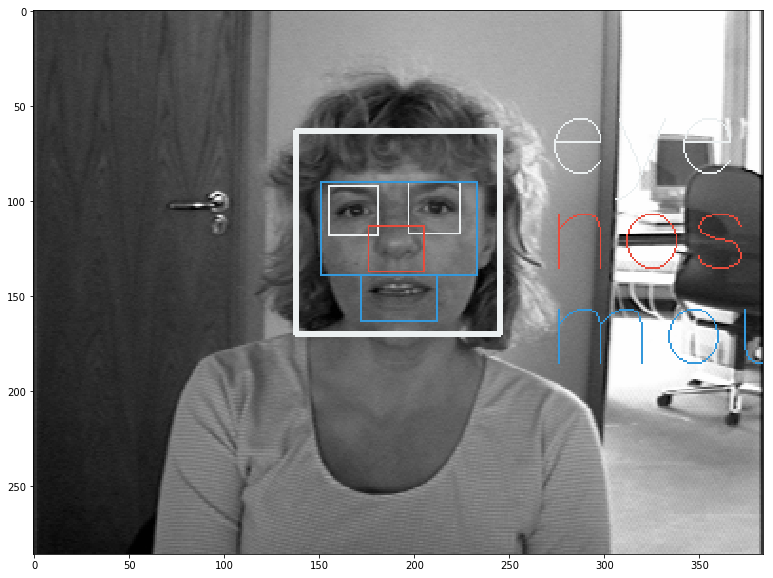

PICTURE ID.:885
printing relative_midpoint_percentage and relative_size_percentage for each detected rectangles:
-------------------- EYES -------------------------
[-21.962616822429908, -10.747663551401869] 5.90444580313
[17.75700934579439, -12.149532710280374] 6.36736832911
-------------------- NOSE -------------------------
[-0.93457943925233633, 7.9439252336448591] 6.07913354878
-------------------- MOUTH -------------------------
[0.46728971962616817, 32.242990654205606] 8.38501179142
[0.46728971962616817, -1.8691588785046727] 35.094768102


In [51]:
imageindex = random.randint(0,len(detected_images))
showImage(drawImageDetection(detected_images[imageindex].image,detected_images[imageindex].result,features))
print('PICTURE ID.:'+str(imageindex))
print('printing relative_midpoint_percentage and relative_size_percentage for each detected rectangles:')
print('-------------------- EYES -------------------------')
for eye in detected_images[imageindex].result[0][0]:
    print(eye.relative_midpoint_percentage,eye.relative_size_percentage)
print('-------------------- NOSE -------------------------')
for nose in detected_images[imageindex].result[0][1]:
    print(nose.relative_midpoint_percentage,nose.relative_size_percentage)
print('-------------------- MOUTH -------------------------')
for mouth in detected_images[imageindex].result[0][2]:
    print(mouth.relative_midpoint_percentage,mouth.relative_size_percentage)

## first eval remarks:
### _positive<br>all the keypoints were found
### _negative<br>without parameterisation or post-detectation filtering, there are too many fals-positive results. 

---
# <center>Grade `Viola-Jones` classifier</center>
#### <center>based on</center>
## <center>BioID Face Database - FaceDB</center> 
---
### <center>consists of 1521 labelled images, 20 keypoints each</center>
![](bioid_keypoints.gif)

`Legend:
There are 20 manually placed points on each 1521 images.
The markup scheme is as follows:
0 = right eye pupil
1 = left eye pupil
2 = right mouth corner
3 = left mouth corner
4 = outer end of right eyebrow
5 = inner end of right eyebrow
6 = inner end of left eyebrow
7 = outer end of left eyebrow
8 = right temple
9 = outer corner of right eye
10 = inner corner of right eye
11 = inner corner of left eye
12 = outer corner of left eye
13 = left temple
14 = tip of nose
15 = right nostril
16 = left nostril
17 = centre point on outer edge of upper lip
18 = centre point on outer edge of lower lip
19 = tip of chin`

### create a  class, holding above mentioned keypoints

In [31]:
class LabelledPicture:
    def __init__(self,picture,right_eye_pupil, left_eye_pupil, right_mouth_corner, left_mouth_corner, outer_end_of_right_eye_brow, inner_end_of_right_eye_brow, inner_end_of_left_eye_brow, outer_end_of_left_eye_brow, right_temple, outer_corner_of_right_eye, inner_corner_of_right_eye, inner_corner_of_left_eye, outer_corner_of_left_eye, left_temple, tip_of_nose, right_nostril, left_nostril, centre_point_on_outer_edge_of_upper_lip, centre_point_on_outer_edge_of_lower_lip, tip_of_chin):
        self.picture = picture
        self.right_eye_pupil = right_eye_pupil
        self.left_eye_pupil = left_eye_pupil
        self.right_mouth_corner = right_mouth_corner
        self.left_mouth_corner = left_mouth_corner
        self.outer_end_of_right_eye_brow = outer_end_of_right_eye_brow
        self.inner_end_of_right_eye_brow = inner_end_of_right_eye_brow
        self.inner_end_of_left_eye_brow = inner_end_of_left_eye_brow
        self.outer_end_of_left_eye_brow = outer_end_of_left_eye_brow
        self.right_temple = right_temple
        self.outer_corner_of_right_eye = outer_corner_of_right_eye
        self.inner_corner_of_right_eye = inner_corner_of_right_eye
        self.inner_corner_of_left_eye = inner_corner_of_left_eye
        self.outer_corner_of_left_eye = outer_corner_of_left_eye
        self.left_temple = left_temple
        self.tip_of_nose = tip_of_nose
        self.right_nostril = right_nostril
        self.left_nostril = left_nostril
        self.centre_point_on_outer_edge_of_upper_lip = centre_point_on_outer_edge_of_upper_lip
        self.centre_point_on_outer_edge_of_lower_lip = centre_point_on_outer_edge_of_lower_lip
        self.tip_of_chin = tip_of_chin
        
        self.mouth_midpoint = [(self.left_mouth_corner[0]+self.right_mouth_corner[0])/2,(self.left_mouth_corner[1]+self.right_mouth_corner[1])/2]

### read BioID Face Database

In [32]:
labelled_pictures = []
directory = './databases/BioID-FaceDatabase-V1/pictures/'

for filename in os.listdir(directory):
    if filename.endswith('.pgm'):
        filepath = os.path.join(directory,filename)
        
        picture = cv2.imread(filepath)
        points_filepath = os.path.join(directory,'points/'+filename[:-4]+'.pts')
        
        points_file = open(points_filepath,'r')
        points_file.seek(29)
        variable_number = -1
        variables = []
        for line in points_file:
            variable_number += 1
            if variable_number <20:
                separator_position = line.find(' ')
                end_position = line.find('\r')
                x = float(line[0:separator_position])
                y = float(line[separator_position+1:end_position])
                variables.append([x,y])
        labelled_pictures.append(LabelledPicture(picture,variables[0], variables[1], variables[2], variables[3], variables[4], variables[5], variables[6], variables[7], variables[8], variables[9], variables[10], variables[11], variables[12], variables[13], variables[14], variables[15], variables[16], variables[17], variables[18], variables[19]))

### evaluate `Viola-Jones` classifier on BioID Database

In [34]:
%%time
# Wall time: 3 min | CPU times: 8min 20s

face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt2.xml')
cascades = []
cascades.append(cv2.CascadeClassifier('haarcascades/haarcascade_eye.xml'))
cascades.append(cv2.CascadeClassifier('haarcascades/haarcascade_mcs_nose.xml'))
cascades.append(cv2.CascadeClassifier('haarcascades/haarcascade_mcs_mouth.xml'))

features = ['eye','nose','mouth'] # used for printing on image

detected_images = []
for element in labelled_pictures:
    filepath = os.path.join(directory,filename)

    image = element.picture
    result = detector(image,face_cascade,cascades)

    detected_images.append(DetectedImage(filename,image,result))

CPU times: user 8min 20s, sys: 1.88 s, total: 8min 22s
Wall time: 3min


**`labelled_pictures`**`: BioID labelled database`<br>
**`detected_images`**`: Viola-Jones detector's result`

### relative_distance counts distance between labelled keypoint and detected keypoint

In [37]:
def relative_distance(labelled_position,detected_position,image_shape):
    absolute_distance = ((labelled_position[0]-detected_position[0])**2+(labelled_position[1]-detected_position[1])**2)**0.5
    image_diagonal = (image_shape[0]**2+image_shape[1]**2)**0.5
    relative_distance = absolute_distance / image_diagonal * 100
    return relative_distance

### Grade holds grade for each `Viola-Jones` detected keypoints
##### grading system will be built on these Class properties

In [87]:
class Grade:
    def __init__(self,face_count,lefteye_found,lefteye_redundant,lefteye_falspositive_counter,righteye_found,righteye_redundant,righteye_falspositive_counter,nose_found,nose_redundant,nose_falspositive_counter,mouth_found,mouth_redundant,mouth_falspositive_counter):

        self.face_count = face_count
        
        self.lefteye_found = lefteye_found
        self.lefteye_redundant = lefteye_redundant
        self.lefteye_falspositive_counter = lefteye_falspositive_counter
        
        self.righteye_found = righteye_found
        self.righteye_redundant = righteye_redundant
        self.righteye_falspositive_counter = righteye_falspositive_counter
        
        self.nose_found = nose_found
        self.nose_redundant = nose_redundant
        self.nose_falspositive_counter = nose_falspositive_counter
        
        self.mouth_found = mouth_found
        self.mouth_redundant = mouth_redundant
        self.mouth_falspositive_counter = mouth_falspositive_counter

### grades is list of Grade – for all the images within dataset

In [88]:
tolerance = 5 # percentage

grades = []

for image_index in range(len(detected_images)):
    
    grade = Grade(0,False,0,0,False,0,0,False,0,0,False,0,0)
    
    image_shape = labelled_pictures[image_index].picture.shape[:2]
    
    labelled_mouth_position = labelled_pictures[image_index].mouth_midpoint
    labelled_nose_position = labelled_pictures[image_index].tip_of_nose
    labelled_lefteye_position = labelled_pictures[image_index].left_eye_pupil
    labelled_righteye_position = labelled_pictures[image_index].right_eye_pupil

    faces = detected_images[image_index].result
    grade.face_count = len(faces)
        
    for face in faces:
        [eyes, noses, mouths] = face
        for eye in eyes:
            if relative_distance(eye.midpoint_global,labelled_lefteye_position,image_shape) < tolerance:
                if grade.lefteye_found == True:
                    grade.lefteye_redundant += 1
                grade.lefteye_found = True
            elif relative_distance(eye.midpoint_global,labelled_righteye_position,image_shape) < tolerance:
                if grade.righteye_found == True:
                    grade.righteye_redundant += 1
                grade.righteye_found = True
            else:
                grade.lefteye_falspositive_counter += 1
                grade.righteye_falspositive_counter += 1
        for nose in noses:
            if relative_distance(nose.midpoint_global,labelled_nose_position,image_shape) < tolerance:
                if grade.nose_found == True:
                    grade.nose_redundant += 1
                grade.nose_found = True
            else:
                grade.nose_falspositive_counter += 1
        for mouth in mouths:
            if relative_distance(mouth.midpoint_global,labelled_mouth_position,image_shape) < tolerance:
                if grade.mouth_found == True:
                    grade.mouth_redundant += 1
                grade.mouth_found = True
            else:
                grade.mouth_falspositive_counter += 1
    grade.cumulated_found = grade.lefteye_found + grade.righteye_found + grade.nose_found + grade.mouth_found
    grade.cumulated_falspositive = grade.lefteye_falspositive_counter + grade.righteye_falspositive_counter + grade.nose_falspositive_counter + grade.mouth_falspositive_counter
    grade.cumulated_redundancy = grade.lefteye_redundant + grade.righteye_redundant + grade.nose_redundant + grade.mouth_redundant
    grades.append(grade)
    

In [202]:
# showImage(image=drawImageDetection(image=detected_images[15].image,result=detected_images[15].result,features=['eye','nose','mouth']))

In [ ]:
for detection in grades:
    if detection.cumulated_found == 4: # means all the subfeatures were found
        if detection.cumulated_falspositive == 0:
            if detection.cumulated_redundancy == 0:
                score = '6'
            else:
                score = '5'
        else:
            score = '4'
    else:
        score = str(detection.cumulated_found)
    if detection.face_count      != 0 and \
       detection.cumulated_found == 0 :
        score = 'r'
        
    if detection.face_count == 1:
        if score != 'r':
            score += '+'
    elif detection.face_count > 1:
        if score != 'r':
            score += '-'
    detection.score = score

In [ ]:
score_count = {'6+':0,'6-':0,'5+':0,'5-':0,'4+':0,'4-':0,'3+':0,'3-':0,'2+':0,'2-':0,'1+':0,'1-':0,'0':0,'r':0,}

for detection in grades:
    score_count[detection.score] += 1

# description of scores

|`score`|                              `detail`                             |`score_count(+,-)`|`rgba_color`     |
|-------| -------------------------------------------------------------------- |-------------|-----------------|
| **6** | all features were found w/o redundancy w/o false_positive detection  |                                         {{score_count['6+'],score_count['6-']}}                                                |rgba(14,173,0,#) |
| **5** | all features were found w/  redundancy w/o false_positive detection  |                                         {{score_count['5+'],score_count['5-']}}                                                |rgba(140,198,0,#)|
| **4** | all features were found w/  redundancy w/  false_positive detection  |                                         {{score_count['4+'],score_count['4-']}}                                                |rgba(150,169,0,#)|
| **3** | 1 feature  was  not found                                            |                                         {{score_count['3+'],score_count['3-']}}                                                |rgba(254,251,2,#)|
| **2** | 2 features were not found                                            |                                         {{score_count['2+'],score_count['2-']}}                                                |rgba(254,196,0,#)|
| **1** | 3 features were not found                                            |                                         {{score_count['1+'],score_count['1-']}}                                                |rgba(255,148,0,#)|
|       |                                                                      |             |                 |
| **+** | only one face was found                                              |             |rgba(#,#,#,1)    |
| **-** | more than one face were found                                        |             |rgba(#,#,#,0.5)  |
|       |                                                                      |             |                 |
| **0** | no faces (therefore no subfeatures) were found                       |                                         {{score_count['0']}}                                                                   |rgba(254,37,0,1) |
| **r** | (r = review) no features were found but a face                       |                                         {{score_count['r']}}                                                                   |rgba(1,162,199,1)|

In [203]:
divisor = sum(list(score_count.values()))

distribution = [ (score_count['6+']+score_count['6-']) / divisor * 100,
                 (score_count['5+']+score_count['5-']) / divisor * 100,
                 (score_count['4+']+score_count['4-']) / divisor * 100,
                 (score_count['3+']+score_count['3-']) / divisor * 100,
                 (score_count['2+']+score_count['2-']) / divisor * 100,
                 (score_count['1+']+score_count['1-']) / divisor * 100,
                 score_count['0'] / divisor * 100,
                 score_count['r'] / divisor * 100
               ]

|                              `detail`                              |percentage|
| ------------------------------------------------------------------ ||
| all features were found w/o redundancy w/o false_positive detection|{{distribution[0]}}|
| all features were found w/  redundancy w/o false_positive detection|{{distribution[1]}}|
| all features were found w/  redundancy w/  false_positive detection|{{distribution[2]}}|
| 1 feature  was  not found                                          |{{distribution[3]}}|
| 2 features were not found                                          |{{distribution[4]}}|
| 3 features were not found                                          |{{distribution[5]}}|
| no faces (therefore no subfeatures) were found                     |{{distribution[6]}}|
| no features were found but a face                                  |{{distribution[7]}}|

In [167]:
colors = ['rgba(14,173,0,1)' ,'rgba(14,173,0,0.65)' ,\
          'rgba(140,198,0,1)','rgba(140,198,0,0.65)',\
          'rgba(150,169,0,1)','rgba(150,169,0,0.65)',\
          'rgba(254,251,2,1)','rgba(254,251,2,0.65)',\
          'rgba(254,196,0,1)','rgba(254,196,0,0.65)',\
          'rgba(255,148,0,1)','rgba(255,148,0,0.65)',\
          'rgba(254,37,0,1)' ,'rgba(1,162,199,1)']

In [179]:
import plotly
from plotly.graph_objs import *

plotly.tools.set_credentials_file(username='makejunk', api_key='RP2u7YG4QuOZe8FcBXU3')
plotly.offline.init_notebook_mode(connected=True)

fig = {
    'data': [
        {
            'values': list(score_count.values()),
            'type': 'pie',
            'labels': labels,
            'marker': {'colors': colors,
                       'line': dict(color='#FFFFFF',width=1)
                      },
            'textinfo':'percent',
            'hoverinfo' : 'label'
        }   ],
    'layout': {
        'title': 'Distribution of scores',
        'showlegend': True,
              }
      }

plotly.plotly.iplot(fig)

In [168]:
import plotly.plotly as py
import plotly.graph_objs as go

labels = list(score_count.keys())
values = list(score_count.values())

trace = go.Pie(labels=labels, values=values,
               hoverinfo='label+percent', textinfo='value', 
               textfont=dict(size=10),
               marker=dict(colors=colors, 
                           line=dict(color='#FFFFFF', width=1)))

py.iplot([trace], filename='styled_pie_chart')

# future ideas
### custom xml files
### alternative method (HOG, SVM)
### CNN